# extract arome wind data and store

Arome grid step is 0.025 deg x 0.025 deg or 2km x 2.8km

10 m/s = ?? Pa = BF = 5BF = 36 km/h = 19 knts

0.1 Pa

In [1]:
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

import pynsitu as pin
crs = pin.maps.crs

----

## wind, arome

To be done on datarmor.
Copy extracted netcdf file back on laptop.


In [2]:
# mission information
cp = pin.Campaign("cswot23.yaml")

# arome output netcdf file
#nc = os.path.join(os.getenv("SCRATCH"), deployment + "_arome.nc")
nc = os.path.join(cp["path_processed"], "arome.nc")

In [3]:
arome_dir = "/home/ref-oc-intranet-restricted/modeles_mf/arome_v2/best_estimate/"

def load_arome(t, dt=None, freq="1H", rkwargs={}, **kwargs):
    """Extract ERA data
    https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5

    Parameters
    ----------
    t: date-like object, list
        date for extraction, [tstart, tend]
    dt: tuple, optional
        time interval in days around t
    freq: str
        frequency of outputs selected, e.g. "1H" or "1D"
    rkwargs: dict
        passed to load_dataset
    **kwargs: passed for direct selection
    """

    if not isinstance(t, list):
        t = [t, t]
    # t = [pd.to_datetime(_t) for _t in t]

    if dt is not None:
        t = [t[0] + pd.Timedelta(days=dt[0]), t[-1] + pd.Timedelta(days=dt[1])]
        t = pd.date_range(t[0], t[-1], freq=freq)
    else:
        t = [t]

    #
    D = []
    for _t in t:
        _rpath = f"{_t.year}/METEOFRANCE_AROME_{_t.year}{_t.month:02d}{_t.day:02d}T{_t.hour:02d}Z*.nc"
        files = glob(os.path.join(arome_dir, _rpath))
        _ds = xr.merge(
            [xr.load_dataset(f, **rkwargs).squeeze().sel(**kwargs) for f in files]
        )
        # renormalize stress by 3600 (presumably dt in seconds)
        _ds["ustress"] = _ds["ustress"]/3600
        _ds["vstress"] = _ds["vstress"]/3600        
        D.append(_ds)
    ds = xr.concat(D, dim="time")

    return ds

In [4]:
dt = (-5, 5)

#
deployment = "cswot23"

#start = pd.Timestamp(2022, 9, 20)
#end = pd.Timestamp(2022, 9, 25)
#lon = slice(4.55, 6.1)
#lat = slice(42.75, 43.45)

start = cp["global"].start.time
end = cp["global"].end.time
extra = 0.1 # extend a bit to make sure cp area is covered
lon= slice(cp["lon"][0]-extra, cp["lon"][1]+extra)
lat = slice(cp["lat"][0]-extra, cp["lat"][1]+extra)

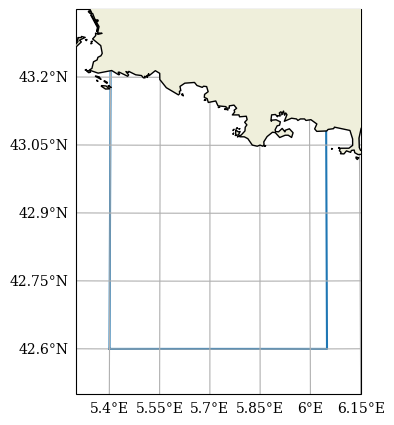

In [5]:
# check extent
fig, ax, _ = pin.maps.plot_map(extent = (lon.start, lon.stop, lat.start, lat.stop), coastline="h")
ax.plot(np.array(cp["lon"])[[0,1,1,0,0]], np.array(cp["lat"])[[0,0,1,1,0]], transform=crs)

In [6]:
ds = load_arome([start, end], dt=dt, longitude=lon, latitude=lat).chunk(
    dict(time="auto")
)

# inspect arome grid steps
#print(ds.longitude.diff("longitude"), ds.latitude.diff("latitude"))
#print(0.025*111, 0.025*111*np.cos(pin.deg2rad*float(ds.latitude.mean())))

ds.to_netcdf(nc, mode="w")

print(f"{nc} written")

/home/datawork-lops-osi/aponte/cswot/drix/clean/arome.nc written


## quick overview

In [7]:
ds = xr.open_dataset(nc)
# add stress
ds["stress"] = np.sqrt(ds["ustress"]**2 + ds["vstress"]**2)
ds

<xarray.Dataset>
Dimensions:    (time: 361, latitude: 35, longitude: 34)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-12T06:00:00 ... 2023-04-27T06:00:00
  * latitude   (latitude) float32 42.5 42.53 42.55 42.58 ... 43.3 43.33 43.35
  * longitude  (longitude) float32 5.3 5.325 5.35 5.375 ... 6.05 6.075 6.1 6.125
    height     float32 ...
Data variables: (12/14)
    hu2m       (time, latitude, longitude) float32 ...
    nebul      (time, latitude, longitude) float32 ...
    pmer       (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    u10m       (time, latitude, longitude) float32 ...
    v10m       (time, latitude, longitude) float32 ...
    ...         ...
    flsolaire  (time, latitude, longitude) float32 ...
    fltherm    (time, latitude, longitude) float32 ...
    ustress    (time, latitude, longitude) float32 -0.03181 -0.03181 ... -0.042
    vstress    (time, latitude, longitude) float32 -0.05783 -0.05894 ... 0.03718
    eau        (time, latitude, longitude) float32 ...
    stress     (time, latitude, longitude) float32 0.066 0.06697 ... 0.0561
Attributes: (12/40)
    data_type:               OCO straight grid
    format_version:          1.2
    title:                   Meteo-France Arome analysis and forecast
    Conventions:             CF-1.3
    netcdf_version:          3.5
    product_name:            METEOFRANCE_AROME_20230412T06Z.nc
    ...                      ...
    data_centre:             CD-OCO
    data_centre_references:  http://www.previmer.org/
    contact:                 cdoco-exploit@ifremer.fr
    distribution_statement:  Data restrictions: for registered users only
    operational_status:      operational
    quality_index:           1

### wind one component snapshot

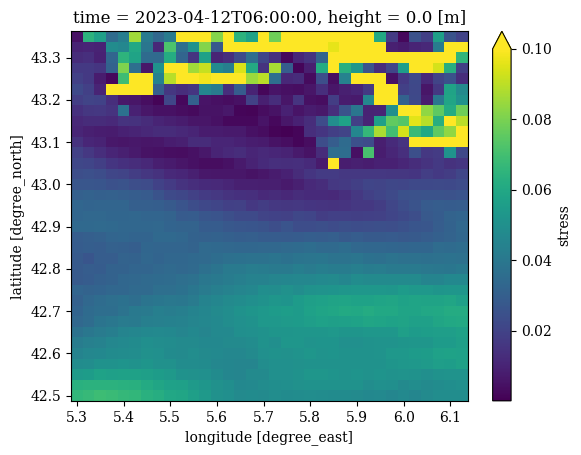

In [9]:
ds.isel(time=0).stress.plot(vmax=.1)

### Hoevmuller

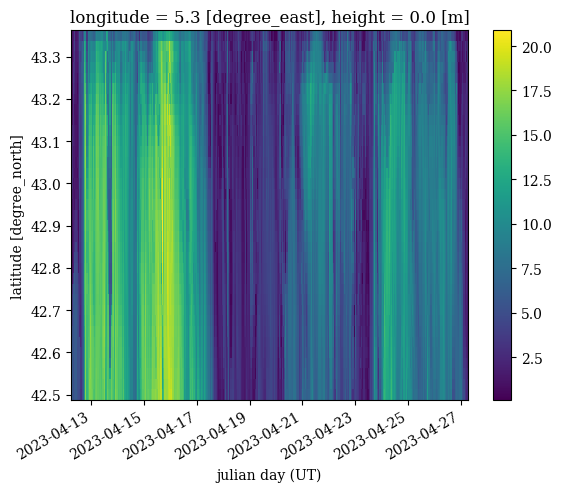

In [10]:
_ds = ds.sel(longitude=5.2, method="nearest")
np.sqrt(_ds.u10m**2 + _ds.v10m**2).plot(x="time")

### map with arrows

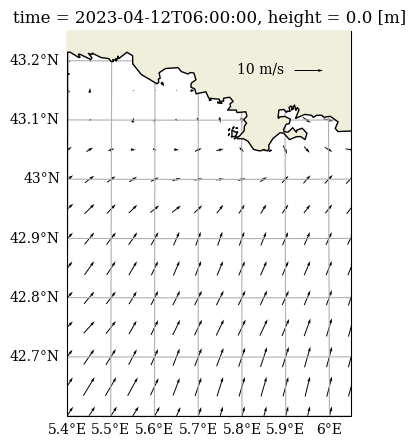

In [11]:
fig, ax, _ = pin.maps.plot_map(extent=cp["lon"]+cp["lat"], coastline="h")

di = 2
_ds = (ds
.sel(time="2022-04-20 00:00:00", method="nearest")
.isel(longitude=slice(0, None, di), latitude=slice(0, None, di))
)

q = _ds.plot.quiver(
    x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2
)
qk = ax.quiverkey(
    q,
    0.8,
    0.9,
    10,
    "10 m/s",
    transform=crs,
    color="k",
    labelpos="W",
    coordinates="axes",
)
qk.set_zorder(10)

### single point time series

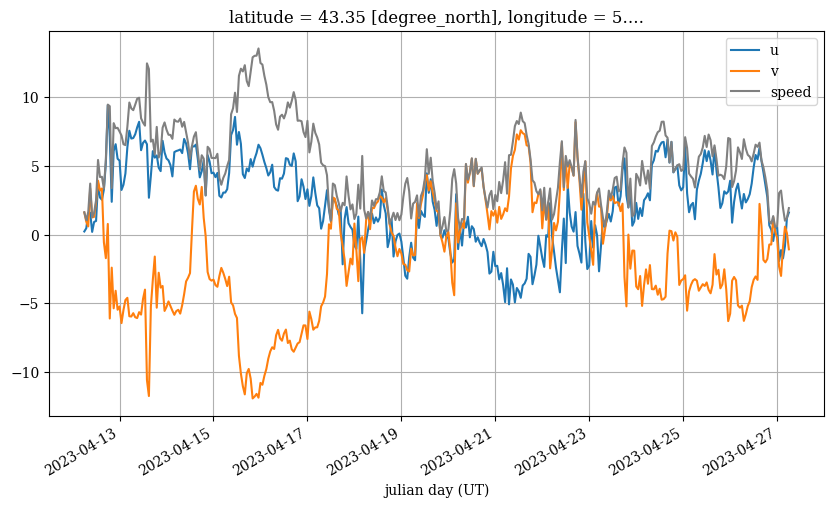

In [12]:
_ds = ds.sel(longitude=5.2, latitude=43.5, method="nearest")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ds.u10m.plot(label="u")
_ds.v10m.plot(label="v")
np.sqrt(_ds.u10m**2 + _ds.v10m**2).plot(label="speed", color="0.5")

ax.grid()
ax.set_ylabel("")
ax.legend()

---

### multiple points interpolation

In [13]:
# define points of interest
lonp = [5.904, 5.904]
latp = [43.045, 42.9]
labels = ["nearshore", "offshore"]

dsp = xr.Dataset(dict(lon=("point", lonp), lat=("point", latp)))
dsp = ds.interp(longitude=dsp.lon, latitude=dsp.lat).assign_coords(
    point=("point", labels)
)
dsp["speed10m"] = np.sqrt(dsp.u10m**2 + dsp.v10m**2)
dsp

<xarray.Dataset>
Dimensions:    (time: 361, point: 2)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-12T06:00:00 ... 2023-04-27T06:00:00
    height     float32 0.0
    longitude  (point) float64 5.904 5.904
    latitude   (point) float64 43.05 42.9
  * point      (point) <U9 'nearshore' 'offshore'
Data variables: (12/15)
    hu2m       (time, point) float64 0.9701 0.9851 0.9736 ... 0.893 0.8932
    nebul      (time, point) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    pmer       (time, point) float64 1.011e+05 1.011e+05 ... 1.016e+05 1.016e+05
    t2m        (time, point) float64 286.7 287.0 285.8 ... 288.3 288.3 288.5
    u10m       (time, point) float64 2.003 2.527 3.872 ... 0.4733 0.3087 0.1672
    v10m       (time, point) float64 -1.881 4.344 2.529 ... 0.3197 0.9824 2.003
    ...         ...
    fltherm    (time, point) float64 -1.381e+05 -2.222e+05 ... -1.843e+05
    ustress    (time, point) float64 -0.008623 -0.01189 ... -0.0005186 -0.000892
    vstress    (time, point) float64 -0.004496 -0.02005 ... -0.000809 -0.002818
    eau        (time, point) float64 0.0 0.0 0.004505 0.003174 ... 0.0 0.0 0.0
    stress     (time, point) float64 0.01024 0.02332 ... 0.000981 0.002956
    speed10m   (time, point) float64 2.747 5.026 4.624 ... 0.5712 1.03 2.01
Attributes: (12/40)
    data_type:               OCO straight grid
    format_version:          1.2
    title:                   Meteo-France Arome analysis and forecast
    Conventions:             CF-1.3
    netcdf_version:          3.5
    product_name:            METEOFRANCE_AROME_20230412T06Z.nc
    ...                      ...
    data_centre:             CD-OCO
    data_centre_references:  http://www.previmer.org/
    contact:                 cdoco-exploit@ifremer.fr
    distribution_statement:  Data restrictions: for registered users only
    operational_status:      operational
    quality_index:           1

#### map with point locations

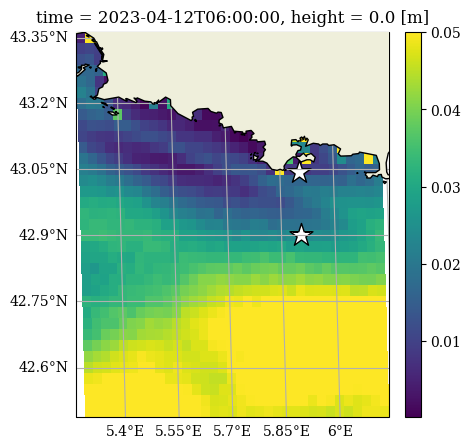

In [14]:
_ds = ds.isel(time=0)
fig, ax, _ = pin.maps.plot_map(_ds.stress, coastline="h", vmax=.05)

ax.scatter(
    x=dsp.longitude,
    y=dsp.latitude,
    s=300,
    facecolor="w",
    edgecolor="k",
    marker="*",
    transform=ccrs.PlateCarree(),
)

### time series

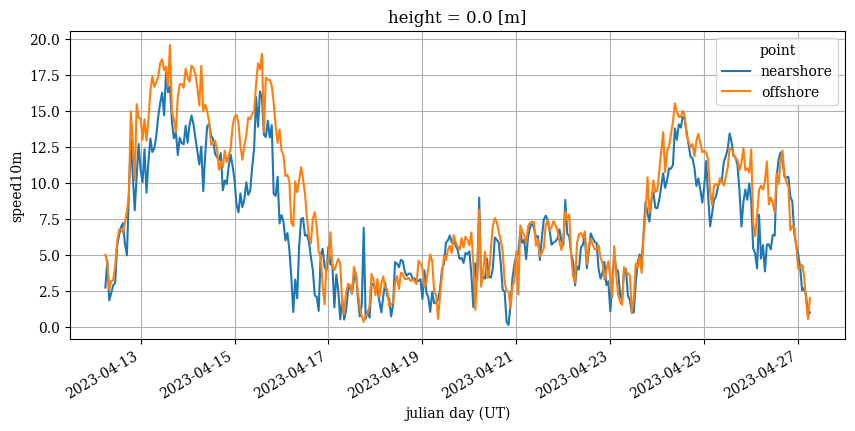

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
dsp.speed10m.plot.line(x="time")
#ax.plot([dinfo["start"], dinfo["end"]], [0, 0], lw=10, color="cadetblue")
ax.grid()

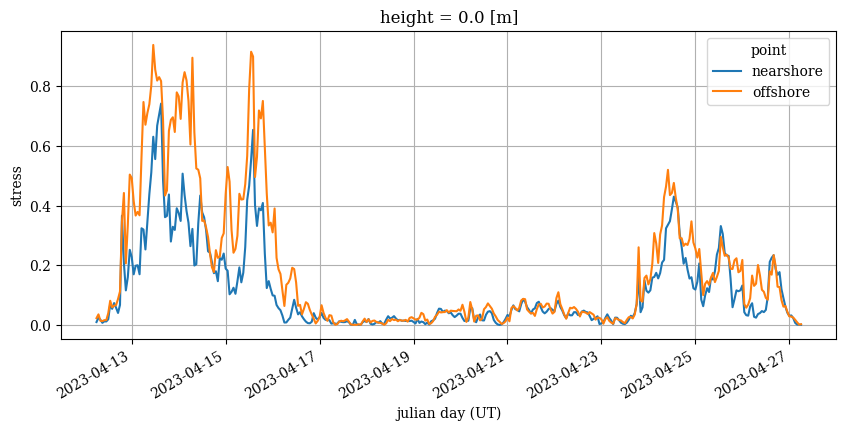

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
dsp.stress.plot.line(x="time")
ax.grid()